# Creating a training database: import and load Pamguard CSV files


(CLICKLEARN DSTI Project)

The objective of this notebook is to complete Ketos *Creating Database (Extended)* notebook:
https://docs.meridian.cs.dal.ca/ketos/tutorials/create_database/index.html

The original notebook *"Chapter 2. Loading the annotations* of the original *Creating Database (Extended)"* describes methods to import CSV files which already match to the Ketos requirements, but not to import and convert other CSV files. 

In the present notebook, sections *1. Imports* and *2. Building annotation files* of the present work complete this chapter 2, by providing methods to load a CSV file exported by **Pamguard software**, and convert it as Ketos annotation table, dealing with datetime and timedelta operations. Pamguard is an open source software which objective is to provide free and easy to handle tools for cetacean passive acoustic monitoring (PAM):
https://www.pamguard.org/

Two types of CSV file exported by Pamguard can be used with these methods. One section of this notebook will be dedicated to each type :

* **Events annotation CSV files**: quoting start and end of time ranges (several seconds long) in which clicks streams have been identified.
* **Clicks annotation CSV files**: quoting start time of identified clicks. Click duration is about few milliseconds and has to be set in parameters (see below).

The converted annotation tables will then be ready to be directly used by Ketos library (see Chapter 3 and followings). No major implementations were provided in Chapter 3 and following ones.


## Contents:

[1. Imports](#section1)  
[2. Building annotation files](#section2)  



<a id=section1></a>

<a id="section1"></a>
## 1. Imports
(CLICKLEARN DSTI)

### Importing the packages

We will use several modules within ketos and also the pandas package



In [43]:
import os
import numpy as np
import pandas as pd
from ketos.data_handling import selection_table as sl
import ketos.data_handling.database_interface as dbi
from ketos.data_handling.parsing import load_audio_representation
from ketos.audio.spectrogram import MagSpectrogram
from ketos.data_handling.parsing import load_audio_representation

from datetime import datetime
from typing import Union
import math
import random

# This last package is made by ClickLearn DSTI team to extract informations from a Pamguard CSV export file 
# and buid a Ketos annotation table (Pandas dataframe)
# import ketos_annotation_table as kat

### Import functions



<span style = "color : red;">
TODO:
    
* Move following methods in Ketos_annotation_table.py when finished, then delete this chapter
</span>


####  <span style = "color : red;"> Must keep [Team] </span>




In [44]:
def strip_dataframe(df):
    """Removes any white space before and after value of every cells of a dataframe.

        Args:
            df: pd.DataFrame
        Returns:
            df: pd.DataFrame
    """
    for column in df:
        if isinstance(df[column][0], str):
            df[column] = df[column].str.strip()
    return df

In [45]:
def subsample_dataframe(df_to_subsample, train_proportion:float):
    """Subsample a Pandas DataFrame into 2 others, based on its indexes.
        
        Args:
            df_to_subsample: pd.DataFrame
            train_proportion: float
                proportion (]0;1[) of indexes to subsample in the dataset, in order to build the train dataset
    
        Returns: tuple with 2 dataframes:
            [0] train subsample 
            [1] test subsamples
    """
    length = len(df_to_subsample)
    nb_train_rows = math.ceil(train_proportion*length)
    #create a sequence corresponding to df indexes to subsample 
    sequence = set(range(length))
    train_indexes = random.sample(sequence, nb_train_rows)
    test_indexes = list(sequence - set(train_indexes))
    return df_to_subsample.iloc[train_indexes], df_to_subsample.iloc[test_indexes]

In [46]:
def check_pamguard_annotation_df(df):
    """Check annotations from a CSV file extracted from Pamguard software. Uses check_annotation in a loop.
    
        Args:
            df: Pandas DataFrame
                Pamguard annotation DataFrame converted by the pamguard_annotations_csv_to_df() method.
        
        Returns: 
            errors: list
                List of errors containing each incorrect annotation
    """
    errors = []
    for index, row in df.iterrows():
        check_annotation_time(row.start, row.end, row.Id)

In [47]:
def check_annotation_time(start:str, end:str, index = 0):
    """Check time validity of 1 annotation (or 1 row of an annotation table): end value must be subsequent to start value.
        Print error messages.
        
        Args:
            start: str
                Start time for the annotation, in seconds from the beginning of the file
            end: str
                End time for the annotation, in seconds from the beginning of the file
            index: int
                Row index (DataFrames)
        
        Returns: 
            str
               String, containing index and details about the incorrect annotation
    
    """
    if start > end: 
        return f'Id {index}: end value ({end}) is prior to start value ({start})'

In [83]:
def pamguard_events_annotations_csv_to_df(annotation_csv_path:str, events_subsampling_option:int = 2):
    """Convert a Pamguard CSV annotation file into a Ketos annotation table (non standardized). 
        Args:
            annotation_csv_path: str
                complete path of the CSV file. CSV separator must be ','
            events_subsampling_option: int
                Subsampling is optional but highly recommended to avoid unsure detections. 
                From the less to the most selective option:
                - 0: no subsampling. All detections (sure, unsure...) are kept
                - 1: subsample excluding all commented detections in 'comment' column 
                    (comments always refer to unsure detections), 
                    then including 'definite' ('DLD') and 'probable' ('DLP') dolphin click detections as well
                - 2 (default value): subsample excluding all commented detections in 'comment' column 
                    (comments always refer to unsure detections), 
                    then including only 'definite' dolphin click detections ('DLD')
               
        Returns:
            annotations_df: pd.DataFrame
                Ketos annotation table (non standardized)
    """

    # annotation_csv_path = csv_events_path
    # events_subsampling_option = 2
    # annotation_type = 'events'
    # click_duration = 2.5

    benchmark_start = datetime.now()

    # import CSV in a dataframe
    annotations_df = pd.read_csv(annotation_csv_path, sep=",")

    # Remove all whitespaces from string typed series of the dataframe 
    annotations_df = strip_dataframe(annotations_df)

    # SUBSAMPLING (SPECIFIC TO EVENT ANNOTATION DF, with option 2 > 1 > 0, check docstring):
    if events_subsampling_option == 2:
        annotations_df = annotations_df.loc[((annotations_df.comment.isna()) 
                                             & (annotations_df.eventType == 'DLD')),]
    if events_subsampling_option == 1:
        annotations_df = annotations_df.loc[(annotations_df.comment.isna()),]    

    # updating pd.Series type from string to datetime
    annotations_df = annotations_df.rename(columns = {'UTC':'start', 'EventEnd':'end', 'eventType':'label'})
    annotations_df.start = pd.to_datetime(annotations_df.start, format = '%Y-%m-%d %H:%M:%S.%f')
    annotations_df.end = pd.to_datetime(annotations_df.end, format = '%Y-%m-%d %H:%M:%S.%f')


    # computing start and end time from beginning of the file
    # + creating a new column to add .wav filenames
    annotations_df['filename']=""
    annotations_df = annotations_df.reset_index()
    for index, row in annotations_df.iterrows():
        try:
            #select all the files that starts before or at the same time than "start", pick the last of them  
            matching_loc = wav_df.loc[(wav_df.filestart <= row.start)].iloc[-1]
            annotations_df.filename[index] = matching_loc['filename']
            annotations_df.start[index] = (annotations_df.start[index] - matching_loc['filestart'])
            annotations_df.end[index] = (annotations_df.end[index] - matching_loc['filestart'])
        except:
            pass


    #convert 'start' in seconds
#     annotations_df['start'] = pd.Series(annotations_df.start).apply(pd.Timedelta.total_seconds)
#     annotations_df['end'] = pd.Series(annotations_df.end).apply(pd.Timedelta.total_seconds)
    annotations_df['start'] = annotations_df.start.apply(pd.Timedelta.total_seconds)
    annotations_df['end'] = annotations_df.end.apply(pd.Timedelta.total_seconds)
    
    # # select only columns required in Ketos annotation table
    annotations_df = annotations_df.loc[:,('Id', 'start', 'end', 'label', 'filename', 'nClicks', 'comment')]


    # Check start and end values of events annotation df
    check_pamguard_annotation_df(annotations_df)
    
    return annotations_df

####  <span style = "color : red;"> Keep or Delete [Team] </span>



In [2]:
def pamguard_name_to_datetime(filename:str):
    """Extract a datetime value from a PAMGUARD sound file name.
        Args:
            filename : str
                PAMGUARD .wav or audio_file name
        Returns:
            datetime
                Formatted datetime value (like 2019-02-24 13:15:00)
        Examples
            >>> pamguard_name_to_datetime('Click_Detector_Sperm_whale_click_detector_Clicks_20180601_010000.pgdf')
            datetime.datetime(2018, 6, 1, 1, 0)
            >>> pamguard_name_to_datetime('192_20180705_123056_853.wav')
            datetime.datetime(2018, 7, 5, 12, 30, 56)
    """
    # split filename from its suffix (.wav or .pgdf)
    filename, suffix = os.path.splitext(filename)
    # remove milliseconds from filename (occurs on Pamguard .wav filenames)
    if ".wav" in suffix:
        filename = filename[:-4]
    # returns the date part of the remaining filename as a datetime
    return datetime.strptime(filename[-15:], '%Y%m%d_%H%M%S')

In [4]:
# NO MORE USED (keep it to detect unmatched labels ?)
def update_annotation_df_labels(annotation_df, labels_to_modify:set, valid_labels: set):
    """Replaces a set of labels with valid labels, in a columns named 'label' of a Pandas Annotation dataframe
        Args:
            annotation_df: pd.DataFrame
                Annotation table imported from Pamguard
            labels_to_modify: set
                set of strings
            valid_labels: set
                set of strings characters corresponding to every valid labels for any annotation

        Returns:
            annotation_df: pd.DataFrame
    """
    # check validity of new labels
    unmatched_labels = set(labels_to_modify.values()) - set(valid_labels)
    if len(unmatched_labels) != 0:
        print('Following labels doesn\'t match label list: ', unmatched_labels)
    else:
        # replace old labels by new ones
        for old_label, new_label in labels_to_modify.items():
            annotation_df.loc[annotation_df.label == old_label,'label'] = new_label
    return annotation_df

## 2. Setting parameters to build the Annotation table 
(CLICKLEARN DSTI Project)


This part contains all required settings to build annotation dataframes:
* Audio files path (where all audio files are stored)
* File path, where: 
    + CSV fils are stored and Annotation tables **will be** stored
    + Sound files are stored
* Click duration in milliseconds (for Click annotation CSV files)
* Set of valid labels to be used (all labels from CSV file that are not matching this set will be stored in an error log file)

In [54]:
# PATH SETTINGS
# Annotation CSV file folder path (MAC)
# annotations_folder_path ='/Users/benoitmialet/Ketos/ClickLearn/'
# Annotation CSV file folder path (W10)
annotations_folder_path = (r'D:\SYSTEL\Ketos\clicklearn')
# Annotation CSV file name
csv_events_name = 'UBISEA_acoustic_detections_samples_events.csv' # WAVFile column was manually added in this file 
csv_clicks_name = 'UBISEA_acoustic_detections_samples_clicks.csv'

# Sound file path (MAC)
# sound_files_path = '/Volumes/BENITO/Pelagis - Données acoustiques ASI/Recordings 048 kHz'
# Sound file path (W10)
sound_files_path = r'F:\Pelagis - Données acoustiques ASI\Recordings 048 kHz'

# PATH BUILDING
csv_folder_path = annotations_folder_path
csv_events_path = os.path.join(csv_folder_path,csv_events_name)
csv_clicks_path = os.path.join(csv_folder_path,csv_clicks_name)

# CLICK ANNOTATION SETTINGS 
# set click duration (milliseconds) for the dataframe
clickDuration = pd.Timedelta(2.5, unit = 'milliseconds')
# set label corresponding to a click detection
label = 'DLD'

# LABELS SETTINGS
# valid labels for annotation dataframes, must be a list (or list of lists)
# each element of the list correspond dto 1 label, ex: ([1,2,[3,3,3],...]):
ketos_signal_labels = [['dolphin_click', 'DLP', 'DLD']]
ketos_signal_labels_all = [['dolphin_click', 'DLP', 'SWC', 'SWB', 'Vn', 'NOTE', 'DLD', 'Vt', 'No']]
ketos_backgr_labels = [] # CHANGE TO ['other']

<a id="section2"></a>
## 2a. Building annotation files from **Events Annotations CSV files** 


This section describes methods to create an annotation table. New methods are added to the original documentation to import Pamguard CSV files.

### steps overview:
* Building a wav_df DataFrame with name and start time of every .wav file in sound files folder and sub folders
* Importing a Pamguard CSV file into a Pandas DataFrame (annotations_df)
* strip blank spaces (strings) in all the annotations_df
* convert 'start' value from string to datetime format
* add and complete 'filename' column, update 'start' column: for each annotations_df 'start' value:
    + select rows in wav_df where 'filestart' value <= 'start' value
    + take last index [-1] of this selection 
    + at this index (wav_df), take 'filename' and 'start' values
    + copy 'filename' into annotations_df 'filename' column
    + update annotations_df 'start' column by computing the time delta in seconds between annotations_df 'start' value and wav_df 'filestart' value
+ add 'end' column, equals to 'start' + 2.5 ms
+ add 'label' column, equals to 'DLD' (Dolphin Definite detection)


### Building a wav_df dataframe with name and start time of every .wav file in sound files folder and sub folders

This dataframe will be used to find on which .wav file each annotation should be attributed

In [68]:
file_list = []
for root, directory, files in os.walk(sound_files_path):
    for file in files:
        if file.endswith('wav'):
            file_list.append([datetime.strptime(file[-23:-4], '%Y%m%d_%H%M%S_%f'), file])

file_list.sort()
wav_df = pd.DataFrame(file_list, columns = ['filestart', 'filename'])
wav_df

,filestart,filename
0,2018-05-28 00:29:02.685,048_20180528_002902_685.wav
1,2018-05-28 00:31:22.520,048_20180528_003122_520.wav
2,2018-05-28 00:32:18.970,048_20180528_003218_970.wav
3,2018-05-28 00:33:02.923,048_20180528_003302_923.wav
4,2018-05-28 00:33:58.587,048_20180528_003358_587.wav
...,...,...
4289,2018-09-28 14:00:00.000,048_20180928_140000_000.wav
4290,2018-09-28 15:00:00.001,048_20180928_150000_001.wav
4291,2018-09-28 16:00:00.000,048_20180928_160000_000.wav
4292,2018-09-28 16:59:59.999,048_20180928_165959_999.wav


### Importing a Pamguard CSV file

CSV files exported by Pamguard software can be converted into a Ketos annotation table.
Export must be done with **default options and default variable names**. This section addresses **"Events"** files. In these files, annotations correspond to groups of clicks observed during time lapses of several seconds.
    + Between EventStart and EventEnd datetime values, a various number of clicks (nClicks) are included.
    + *use method with parameters annotation_type == 'events' and  events_subsampling_option (report to the method's docstring)*
    + In the CSV files, columns **in bold** are required and must have **exactely the same headers** as followig: 

![Pamguard event csv](img/capture_PAMGUARD_event_csv.png)




Now we use the pamguard_events_annotations_csv_to_df() method to import the CSV file into a data frame. We will use subsampling_option = 2, to select only the dolphin definite detection (DLD) labels

Subsampling_option is optional but highly recommended to avoid unsure detections. Several subsamplings of annotations_csv_df are possible, from the less to the most selective option:
- 0: no subsampling. All detections (sure, unsure...) are kept
- 1: subsample excluding all commented detections in 'comment' column 
    (comments always refer to unsure detections), 
    then including 'definite' ('DLD') and 'probable' ('DLP') dolphin click detections as well
- 2 (default value): subsample excluding all commented detections in 'comment' column 
    (comments always refer to unsure detections), 
    then including only 'definite' dolphin click detections ('DLD')
N.B.: Clicks annotation CSV files are only based on (uncommented) definite dolphin click 
detections ('DLD'), so it is unnecessary to subsample them regarding to any comment or label. 

In [85]:
annotations_df = pamguard_events_annotations_csv_to_df(csv_events_path, events_subsampling_option = 2)
annotations_df.head(5)

,Id,start,end,label,filename,nClicks,comment
0,48,570.912,695.107,DLD,048_20180603_035959_999.wav,362,NaN
1,57,2013.163,2068.447,DLD,048_20180611_110000_001.wav,100,NaN
2,313,108.851,478.894,DLD,048_20180720_205959_999.wav,610,NaN
3,314,3364.329,4708.903,DLD,048_20180721_090000_000.wav,386,NaN
4,320,1452.926,1496.650,DLD,048_20180722_185959_933.wav,137,NaN


The returned annotation_df data frame is not yet standardized and thus can be modified or processed. The columns indicate:

**start:** start time for the annotation, in seconds from the beginning of the file  
**end:** end time for the annotation, in seconds from the beginning of the file   
**label:** label for the annotation
**filename:** name of the audio file  

In [86]:
#label check
annotations_df.label.unique()

array(['DLD'], dtype=object)

We now also build an annotations_df_no_subsample which will contain all labels, even the unsure ones. 
We will use this dataframe later in this notebook to build backround noise labels.

In [87]:
annotations_df_no_subsample = pamguard_events_annotations_csv_to_df(csv_events_path, events_subsampling_option = 0)
annotations_df_no_subsample.head(5)

,Id,start,end,label,filename,nClicks,comment
0,1,613.934,703.488,DLP,048_20180528_210000_001.wav,288,Test
1,2,783.242,852.485,DLP,048_20180528_210000_001.wav,125,Test
2,3,195.787,549.103,SWC,048_20180529_220000_001.wav,245,NaN
3,4,232.087,1223.587,SWC,048_20180529_220000_001.wav,374,NaN
4,5,628.864,874.817,SWC,048_20180529_220000_001.wav,115,NaN


In [88]:
#label check
annotations_df_no_subsample.label.unique()

array(['DLP', 'SWC', 'SWB', 'Vn', 'NOTE', 'DLD', 'Vt', 'No'], dtype=object)

We export csv versions of the annotation table

In [47]:
#first csv export of the annotation table to check if row start time matches with wav file name 
csv_events_annotations_path = os.path.join(csv_folder_path,'annotations_events.csv')
annotations_df.to_csv(csv_events_annotations_path)

### Optional : Splitting into 2 random subsamples (annotation_train / annotation_test)
**<span style = 'color:red;'> [PLEASE SKIP THIS SECTION]: Ketos framework seems to not use random annotations subsampling based on same audio files but works with train and test annotations made on different sound files. So we won't use this section for our first training. </span>**

We created subsample_dataframe() method to split the annotation table into 2 subsamples:
* Train annotation table (Ketos will use it to create the training dataset)
* Test annotation table (Ketos will use it to create the testing dataset)

In [28]:
help(subsample_dataframe)

Help on function subsample_dataframe in module __main__:

subsample_dataframe(df_to_subsample, train_proportion: float)
    Subsample a Pandas DataFrame into 2 others, based on its indexes.
    
    Args:
        df_to_subsample: pd.DataFrame
        train_proportion: float
            proportion (]0;1[) of indexes to subsample in the dataset, in order to build the train dataset
    
    Returns: tuple with 2 dataframes:
        [0] train subsample 
        [1] test subsamples



In [21]:
# std_annot_train_events = subsample_dataframe(std_events_annot_df, 0.7)[0]
# std_annot_test_events = subsample_dataframe(std_events_annot_df, 0.7)[1]

std_annot_train  = subsample_dataframe(std_annot_df, 0.7)[0]
std_annot_test = subsample_dataframe(std_annot_df, 0.7)[1]

In [47]:
print(std_annot_train.shape, std_annot_test.shape)

(528, 6)

### Standardize Ketos annotation tables
ketos.data_handling.selection_table.standardize() is the original method to standardize an annotation table for Ketos once it is built. ketos.data_handling.selection_table.is_standardized() checks if this standardization is completed or return error description.

(ClickLearn DSTI team remark :) If *signal_labels* and *backgr_labels* arguments are used, skip section 6 as background background noise will correspond to label 0 and will not need random generation

In [29]:
# previously built dataframe version
# events_annot_df = annotations_df

In [9]:
# csv import version
annot_df = pd.read_csv(os.path.join(annotations_folder_path, 'annotations_events.csv'), sep=",")

annot_train_df = pd.read_csv(os.path.join(annotations_folder_path, 'annotations_events_train.csv'), sep=",")
annot_test_df = pd.read_csv(os.path.join(annotations_folder_path, 'annotations_events_test.csv'), sep=",")

Ketos allows to differenciate 1 or several positive signal labels, which will be translated as '1','2', etc., and 1 or several background labels which will be translated as '0'. Both positive and negative labels have to be put into a list. For a first training, we will use only 1 positive label (1) and 1 negative label (0)

In [10]:
# standardize all annotation tables
# std_events_annot_df = sl.standardize(table = events_annot_df, signal_labels = ketos_signal_labels, trim_table=False)
# std_clicks_annot_df = sl.standardize(table = clicks_annot_df, signal_labels = ketos_signal_labels, trim_table=False)

std_annot_train_df = sl.standardize(
    table = annot_train_df, 
    signal_labels = ketos_signal_labels,
    backgr_labels= ketos_backgr_labels,
    trim_table=False
)

std_annot_test_df = sl.standardize(
    table = annot_test_df, 
    signal_labels = ketos_signal_labels,
    backgr_labels= ketos_backgr_labels,
    trim_table=False
)

print('check if files are in standardized format:\n', 
      sl.is_standardized(std_annot_train_df), '\n',
     sl.is_standardized(std_annot_test_df))

check if files are in standardized format:
 True 
 True


In [11]:
std_annot_train_df.head(5)

Unnamed: 0   Id    start      end  \
filename                    annot_id                                      
048_20180601_205959_933.wav 0                 23  479  306.173  324.690   
                            1                 24  482  548.545  574.699   
                            2                 25  483  606.638  620.533   
                            3                 26  484  638.642  650.067   
                            4                 27  485  662.602  670.766   

                                      label  nClicks  comment  
filename                    annot_id                           
048_20180601_205959_933.wav 0             1      111      NaN  
                            1             1       60      NaN  
                            2             1       89      NaN  
                            3             1       39      NaN  
                            4             1       36      NaN

In [12]:
std_annot_test_df.head(5)

Unnamed: 0   Id     start       end  \
filename                    annot_id                                        
048_20180601_075959_932.wav 0                 16  465   768.317   812.268   
                            1                 17  466  1499.303  1525.846   
048_20180601_185959_933.wav 0                 18  469  1424.649  1461.736   
                            1                 19  473  2530.080  2553.448   
                            2                 20  474  2722.413  2776.792   

                                      label  nClicks  comment  
filename                    annot_id                           
048_20180601_075959_932.wav 0             1      108      NaN  
                            1             1      130      NaN  
048_20180601_185959_933.wav 0             1       93      NaN  
                            1             1       10      NaN  
                            2             1      126      NaN

let's check if train and test df are using different audio files (seems to be required by Ketos). the result should be an empty set:

In [32]:
set(std_annot_test_df.index.unique()) & set(std_annot_train_df.index.unique())

set()

## 2b. Building annotation files from Clicks Annotations CSV files
**<span style = 'color:red;'> [PLEASE SKIP ENTIRELY SECTION 2b]: First tests shown that using 2.5 ms sound samples does not seem to suit the use of spectrograms (only few pixels are displayed) and need more inquiry before going further. Thus, for this project, only Event annotation will be used to train a model.</span>**

### Importing a Pamguard CSV file

CSV files exported by Pamguard software can be converted into a Ketos annotation table.
Export must be done with **default options and default variable names**. This section addresses **"clicks"** files. In these files, annotations correspond to begin time of clicks ('UTC', datetime). End time values ('end', datetime) values are automatically computed by setting a click duration ('click_duration') in milliseconds in parameters. 
    Clickend will simply be the result of begin time + click_duration. In the CSV files, columns **in bold** are required and must have **exactely the same headers** as followig:

![Pamguard click csv](img/capture_PAMGUARD_click_csv.png)


**<span style = 'color:red;'>Careful, executing the following cell can take more than 20 minutes !</span>**

In [116]:
annotation_csv_path = csv_clicks_path
# annotation_type = 'clicks'
click_duration = 2.5

benchmark_start = datetime.now()

# import CSV in a dataframe
annotations_df = pd.read_csv(annotation_csv_path, sep=",")

# Remove all whitespaces from string typed series of the dataframe 
annotations_df = strip_dataframe(annotations_df)

# updating pd.Series type from string to datetime
annotations_df.UTC = pd.to_datetime(annotations_df.UTC, format = '%Y-%m-%d %H:%M:%S.%f')
annotations_df = annotations_df.rename(columns = {'UTC':'start'})

# computing start time from beginning of the file
# + creating a new column to add .wav filenames
annotations_df['filename']=""
for index, row in annotations_df.iterrows():
    try:
        #select all the files that starts before or at the same time than "start", pick the last of them  
        matching_loc = wav_df.loc[(wav_df.filestart <= row.start)].iloc[-1]
        annotations_df.filename[index] = matching_loc['filename']
        annotations_df.start[index] = (annotations_df.start[index] - matching_loc['filestart'])
    except:
        pass
    
# Converts click_duration into Timedelta format
click_duration = pd.Timedelta(click_duration, unit = 'milliseconds')

# Compute 'end' time thanks to click duration then convert it in seconds
annotations_df['end'] = pd.Series(annotations_df.start + click_duration).apply(pd.Timedelta.total_seconds)

#convert 'start' in seconds
annotations_df['start'] = pd.Series(annotations_df.start).apply(pd.Timedelta.total_seconds)

# add a default label for each click detection (DLD)
annotations_df['label'] = label

# select only columns required in Ketos annotation table
annotations_df = annotations_df.loc[:,('Id', 'EventId', 'start', 'end', 'label', 'filename')]

benchmark_end = datetime.now()
benchmark = benchmark_end - benchmark_start

In [119]:
benchmark

datetime.timedelta(seconds=1434, microseconds=982409)

### Standardize Ketos annotation tables
ketos.data_handling.selection_table.standardize() is the original method to standardize an annotation table for Ketos once it is built. ketos.data_handling.selection_table.is_standardized() checks if this standardization is completed or return error description.

In [33]:
#first csv export of the annotation table to check if row start time matches with wav file name 
csv_clicks_annotations_path = os.path.join(csv_folder_path,'annotations_clicks.csv')
annotations_df.to_csv(csv_clicks_annotations_path)

In [122]:
# previously built dataframe version
clicks_annot_df = annotations_df

In [38]:
# csv import version
annot_df = pd.read_csv(os.path.join(annotations_folder_path, 'annotations_clicks.csv'), sep=",")

# For a first training, we will use a limited amount of data
annot_train_df = pd.read_csv(os.path.join(annotations_folder_path, 'annotations_clicks_train_short.csv'), sep=",")
annot_test_df = pd.read_csv(os.path.join(annotations_folder_path, 'annotations_clicks_test_short.csv'), sep=",")

In [33]:
std_clicks_annot_train_df = sl.standardize(
    table = annot_train_df, 
    signal_labels = ketos_signal_labels,
    backgr_labels= ketos_backgr_labels,
    trim_table=False
)

std_clicks_annot_test_df = sl.standardize(
    table = annot_test_df, 
    signal_labels = ketos_signal_labels,
    backgr_labels= ketos_backgr_labels,
    trim_table=False
)

print('check if files are in standardized format:\n', 
#      sl.is_standardized(std_events_annot_df), '\n',
      sl.is_standardized(std_clicks_annot_train_df), '\n',
     sl.is_standardized(std_clicks_annot_test_df))

In [46]:
std_clicks_annot_train_df

Unnamed: 0      Id  EventId     start  \
filename                    annot_id                                          
048_20180528_210000_001.wav 0                  0       1        1   613.934   
                            1                  1       2        1   614.095   
                            2                  2       3        1   614.623   
                            3                  3       4        1   614.986   
                            4                  4       5        1   616.752   
...                                          ...     ...      ...       ...   
048_20180529_220000_001.wav 1343          172532  175726        4  1044.940   
                            1344          172533  175727        4  1061.052   
                            1345          172534  175728        4  1063.327   
                            1346          172535  175729        4  1067.955   
                            1347          172536  175730        4  1068.768   

                                            end  label  
filename                    annot_id                    
048_20180528_210000_001.wav 0          613.9365      1  
                            1          614.0975      1  
                            2          614.6255      1  
                            3          614.9885      1  
                            4          616.7545      1  
...                                         ...    ...  
048_20180529_220000_001.wav 1343      1044.9425      1  
                            1344      1061.0545      1  
                            1345      1063.3295      1  
                            1346      1067.9575      1  
                            1347      1068.7705      1  

[1761 rows x 6 columns]

In [49]:
std_clicks_annot_test_df

Unnamed: 0    Id  EventId     start  \
filename                    annot_id                                        
048_20180529_225959_999.wav 0               1718  1868       12  1030.918   
                            1               1719  1869       12  1031.029   
                            2               1720  1870       12  1043.917   
                            3               1721  1871       12  1044.492   
                            4               1722  1872       12  1044.733   
...                                          ...   ...      ...       ...   
                            3064            4782  4932       12  1576.941   
                            3065            4783  4933       12  1578.048   
                            3066            4784  4934       12  1578.412   
                            3067            4785  4935       12  1579.943   
                            3068            4786  4936       12  1581.316   

                                            end  label  
filename                    annot_id                    
048_20180529_225959_999.wav 0         1030.9205      1  
                            1         1031.0315      1  
                            2         1043.9195      1  
                            3         1044.4945      1  
                            4         1044.7355      1  
...                                         ...    ...  
                            3064      1576.9435      1  
                            3065      1578.0505      1  
                            3066      1578.4145      1  
                            3067      1579.9455      1  
                            3068      1581.3185      1  

[3069 rows x 6 columns]

## 3. Moving all .WAV files in a same folder
**<span style = 'color:red;'> [PLEASE SKIP THIS SECTION] : For the purpose of the project, this step has already been executed and doesn't need to be executed again.</span>**

Pelagis .wav files were split into folders and sub folders. The objective of the code cell was to gather .wav file in the parent folder so that Ketos could work and build its spectra database from a single folder as required by the documentation. 


In [29]:
from os.path import join, isdir
from os import listdir, rmdir
from shutil import move

root = sound_files_path

for dirname in listdir(root):
    #only take directories (not files) 
    if isdir(join(root, dirname)):
        # move every wav into the parent directory
        for filename in listdir(join(root, dirname)):
            if filename.endswith('.wav'):
                move(join(root, dirname, filename), join(root, filename))


------

**Starting from here, following text is taken from the orginial Notebook, with no major implementation from ClickLearn DSTI project team. 
Only some line of codes which are specific to the project needs were added.**

**The train and test files are now ready to be used in step *5. Creating segments of uniform length* and following ones from the original Notebook.**





<a id=section3></a>

## 5. Creating segments of uniform length and augmenting the data

Our `` std_annot_train`` and ```std_annot_test``` have a variety of lengths, since they mark the beginning and end of events. We want each signal in the database to be represented as spectrograms, all of same length. Each spectrogram will be labelled as containing a train of clicks or not. 

The ```sl.select``` function in ketos can help us to do just that: for each annotated upcall, it will select a portion of the recording surrounding it. It takes a standardized annotation table as input. We will use 4 seconds as it seems enough to encompass a train of clicks among annotated events.

Data augmentation is a set of tecnhiques used in machine learning to increase the data available. For now we use  a very safe technique with ```sl.select``` method, as it is not altering the original signal

This table contains only positive annotations (trains of clicks). Later we will also want some examples of segments that only contain background noise.


* **length** (seconds): uniform length of a segment
* **step** (seconds): shift between 2 segments (no shift if length == step). Smaller values will produce more augmented selections, but they will be more similar to the previous selection.
* **min_overlap** (proportion): if a segment crosses the start or the end of annotation, 
    proportion of its length that is allowed to cross (1 means no cross allowed). Lower values will result in segments that only contain part of the original upcall. We fix 50%

In [38]:
# positives_train_events = sl.select(annotations=std_annot_train_events, length=0.5, step=0.5, min_overlap=1, center=False, discard_long=False, keep_id=False)
# positives_test_events = sl.select(annotations=std_annot_test_events, length=0.5, step=0.5, min_overlap=1, center=False, discard_long=False, keep_id=False)

positives_train = sl.select(annotations=std_annot_train_df, length=3, step=1, min_overlap=0.4, center=False, discard_long=False, keep_id=False)
positives_test = sl.select(annotations=std_annot_test_df, length=3, step=1, min_overlap=0.4, center=False, discard_long=False, keep_id=False)


In [54]:
# CLICK VERSION
# positives_train_clicks = sl.select(annotations=std_clicks_annot_train_df, length=0.0025, step=0.0025, min_overlap=1, center=False, discard_long=False, keep_id=False)
# positives_test_clicks = sl.select(annotations=std_clicks_annot_test_df, length=0.0025, step=0.0025, min_overlap=1, center=False, discard_long=False, keep_id=False)

In [37]:
#some information
mean = (positives_train['end']-positives_train['start']).values.mean()
print(f'Shape of positive_train df: {positives_train.shape}\n',
      f'Shape of positive_test df: {positives_test.shape}\n',
      f'segment mean length (seconds): {mean}\n',
     )

Shape of positive_train df: (536, 7)
 Shape of positive_test df: (187, 7)
 segment mean length (seconds): 2.0



In [109]:
# Original Ketos documentation:
# positives_train = sl.select(annotations=std_annot_train, length=3.0)
# positives_test = sl.select(annotations=std_annot_test, length=3.0, step=0.0, center=False)

<a id=section6></a> 

## 6. Including background noise

Now that we have the positive instances that we need to create our database, we need to include some examples of the negative class, or instances without upcalls.

The ```sl.create_rndm_backgr_selections``` is ideal for our situation. It takes a standardized ketos table describing all sections of the recordings that contain annotations and takes samples from the non-annotaded portions of the files, assuming everything that is not annotated can be used as a 'background' category.

**Note**:
You might find yourself in a different scenario. For example, your annotations might already include a 'background' class or you might have annoted different classes of sounds and you only want to use a few of them. In any case, ketos provides a variety of other functions that are helpful in different scenarios. Have a look at the documentation for more details. Specially the ```selection_table``` module.



In [92]:
# sl.create_rndm_backgr_selections(std_annot_test_clicks, len(std_annot_test_clicks), 12, annotations=None, no_overlap=False, trim_table=False)

The ```sl.create_rndm_backgr_selections``` also needs the duration of each file, which we can generate using the ```sl.file_duration``` function.

In [117]:
file_durations_train = sl.file_duration_table('data/train')
file_durations_test = sl.file_duration_table('data/test') 

In [115]:
file_durations_train

,filename,duration
0,048_20180601_205959_933.wav,3600.067
1,048_20180601_220000_000.wav,3600.000


In [116]:
file_durations_test

,filename,duration
0,048_20180601_075959_932.wav,3600.068
1,048_20180601_185959_933.wav,3600.067


Now that we have the file durations, we can generate our table of negative segments. We'll specify the same length (3.0 seconds). The ```num``` argument specifies the number of background segments we would like to generate. Let's make this number equal to the number of positive examples in each dataset (```len(positive_train)``` and ``` len(positive_test)```)

#### Clicks 

In [46]:
negatives_train=sl.create_rndm_backgr_selections(annotations=std_annot_train_clicks, files=file_durations_train_clicks, length=0.0025, num=len(positives_train_clicks), trim_table=True)

In [47]:
negatives_test=sl.create_rndm_backgr_selections(annotations=std_annot_test_clicks, files=file_durations_test_clicks, length=0.0025, num=len(positives_test_clicks), trim_table=True)

#### Events

To create negative trains, we will use annotations_df_no_subsample dataframe that we created in section 2a (which includes all positive annotations, including unsure ones). We will use the same duration of course.

In [119]:
negatives_train=sl.create_rndm_backgr_selections(annotations=annotations_df_no_subsample, files=file_durations_train, length=4, num=len(positives_train), trim_table=True)
negatives_test=sl.create_rndm_backgr_selections(annotations=annotations_df_no_subsample, files=file_durations_test, length=4, num=len(positives_test), trim_table=True)

In [120]:
negatives_train

start          end  label
filename                    sel_id                                 
048_20180601_205959_933.wav 0          7.725739    11.725739      0
                            1         19.157327    23.157327      0
                            2         35.762859    39.762859      0
                            3         42.950751    46.950751      0
                            4         46.422663    50.422663      0
...                                         ...          ...    ...
048_20180601_220000_000.wav 267     3543.829199  3547.829199      0
                            268     3548.301840  3552.301840      0
                            269     3569.122561  3573.122561      0
                            270     3591.151531  3595.151531      0
                            271     3591.973469  3595.973469      0

[543 rows x 3 columns]

In [121]:
negatives_test

start          end  label
filename                    sel_id                                 
048_20180601_075959_932.wav 0         16.531581    20.531581      0
                            1         19.657702    23.657702      0
                            2         22.589602    26.589602      0
                            3         56.227939    60.227939      0
                            4         77.341488    81.341488      0
...                                         ...          ...    ...
048_20180601_185959_933.wav 92      3432.874185  3436.874185      0
                            93      3447.514166  3451.514166      0
                            94      3529.386532  3533.386532      0
                            95      3548.562152  3552.562152      0
                            96      3551.442812  3555.442812      0

[191 rows x 3 columns]

Finally, we'll just put the ```positives_train``` and ```negatives_train``` together and do the same to the test tables.

In [122]:
selections_train = positives_train.append(negatives_train, sort=False)
selections_test = positives_test.append(negatives_test, sort=False)

In [315]:
selections_train

Unnamed: 0     Id  label  nClicks  \
filename                    sel_id                                      
048_20180601_205959_933.wav 0             23.0  479.0      1    111.0   
                            1             23.0  479.0      1    111.0   
                            2             23.0  479.0      1    111.0   
                            3             23.0  479.0      1    111.0   
                            4             23.0  479.0      1    111.0   
...                                        ...    ...    ...      ...   
048_20180601_220000_000.wav 267            NaN    NaN      0      NaN   
                            268            NaN    NaN      0      NaN   
                            269            NaN    NaN      0      NaN   
                            270            NaN    NaN      0      NaN   
                            271            NaN    NaN      0      NaN   

                                    comment        start          end  
filename                    sel_id                                     
048_20180601_205959_933.wav 0           NaN   304.285851   308.285851  
                            1           NaN   305.285851   309.285851  
                            2           NaN   306.285851   310.285851  
                            3           NaN   307.285851   311.285851  
                            4           NaN   308.285851   312.285851  
...                                     ...          ...          ...  
048_20180601_220000_000.wav 267         NaN  3543.829199  3547.829199  
                            268         NaN  3548.301840  3552.301840  
                            269         NaN  3569.122561  3573.122561  
                            270         NaN  3591.151531  3595.151531  
                            271         NaN  3591.973469  3595.973469  

[1086 rows x 7 columns]

In [303]:
selections_test

Unnamed: 0     Id  label  nClicks  \
filename                    sel_id                                      
048_20180601_075959_932.wav 0             16.0  465.0      1    108.0   
                            1             16.0  465.0      1    108.0   
                            2             16.0  465.0      1    108.0   
                            3             16.0  465.0      1    108.0   
                            4             16.0  465.0      1    108.0   
...                                        ...    ...    ...      ...   
048_20180601_185959_933.wav 92             NaN    NaN      0      NaN   
                            93             NaN    NaN      0      NaN   
                            94             NaN    NaN      0      NaN   
                            95             NaN    NaN      0      NaN   
                            96             NaN    NaN      0      NaN   

                                    comment        start          end  
filename                    sel_id                                     
048_20180601_075959_932.wav 0           NaN   766.530193   770.530193  
                            1           NaN   767.530193   771.530193  
                            2           NaN   768.530193   772.530193  
                            3           NaN   769.530193   773.530193  
                            4           NaN   770.530193   774.530193  
...                                     ...          ...          ...  
048_20180601_185959_933.wav 92          NaN  3432.874185  3436.874185  
                            93          NaN  3447.514166  3451.514166  
                            94          NaN  3529.386532  3533.386532  
                            95          NaN  3548.562152  3552.562152  
                            96          NaN  3551.442812  3555.442812  

[382 rows x 7 columns]

At this point, we have defined *which* audio segments we want in our database: 50% with click trains and 50% without, and same ratio for the test set.

Now we need to decide *how* these segments will be represented.

<a id=section7></a>

###  7. Choosing the spectrogram settings

As mentioned earlier, we'll represent the segments as spectrograms.
In the .zip file where you found the data, there's also a spectrogram configuration file (```spec_config.json```) which contains the settings we want to use.

This configuration file is simply a text file in the ```.json``` format, so you could make a copy of it, change a few parameters and save several settings to use later or to share the with someone else.


In [39]:
import matplotlib.pyplot as plt

In [40]:
spec_config = load_audio_representation('spec_config.json', name="spectrogram")
spec_config

{'type': 'MagSpectrogram',
 'rate': 1000,
 'window': 0.256,
 'step': 0.032,
 'freq_min': 0,
 'freq_max': 500,
 'window_func': 'hamming'}

Let's have a first look at one example of click detection, using MagSpectrogram.from_wav method. We will take one of the annotations from our train set:

In [41]:
annotations_df.loc[annotations_df['Id'] == 479]

NameError: name 'annotations_df' is not defined

In [321]:
# compute the spectrogram of the 1st upcall, using the spectrogram parameters loaded from the saved model
spec1 = MagSpectrogram.from_wav(
    path='/Volumes/BENITO/Pelagis - Données acoustiques ASI/Recordings 048 kHz/048_20180601_205959_933.wav',
    offset=309.173, #- 0.5*spec_config['duration'],
    **spec_config)

spec1.plot() #create the figure
plt.show()  #display it

We explore a little bit different possible audio representations

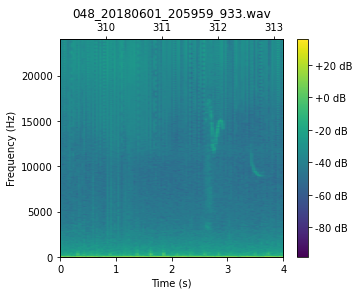

In [339]:
#shorter window, second stereo channel 
spec_config = {
    'channel': 1, #stereo channel (0 by default)
    'type': 'MagSpectrogram',
#      'rate': 1000, #None = use original rate
     'window': 0.1,
     'step': 0.032,
     'freq_min': 0,
     'freq_max': 25000,
     'window_func': 'hamming',
     'duration': 4
    }

spec2 = MagSpectrogram.from_wav(
    path='/Volumes/BENITO/Pelagis - Données acoustiques ASI/Recordings 048 kHz/048_20180601_205959_933.wav',
    offset=309.173, #- 0.5*spec_config['duration'],
    **spec_config)
spec2.plot()
plt.show()

<a id=section8></a>

### 8. Creating the database

Now we have to compute the spectrograms following the settings above for each selection in our selection tables and then save them in a database.

All of this can be done with the ```dbi.create_database``` function in Ketos.

We will start with the training dataset. We need to indicate the name for the database we want to create, where the audio files are, a name for the dataset, the selections table and, finally the audio representation. As specified in our ``spec_cfg``, this is a Magnitude spectrogram, but ketos can also create databases with Power, Mel and CQT spectrograms, as well as time-domain data (waveforms).


In [340]:
spec_config = {
#     'channel': 1, #stereo channel (0 by default)
    'type': 'MagSpectrogram',
#      'rate': 1000, #None = use original rate
     'window': 0.1,
     'step': 0.032,
     'freq_min': 0,
     'freq_max': 25000,
     'window_func': 'hamming',
     'duration': 4
    }
#channel arg is shared with create_database method, that's why we move it there:
dbi.create_database(output_file='database_01.h5', 
                    channel = 1,
                    data_dir='data/train',
                    dataset_name='train',
                    selections=selections_train,
                    audio_repres=spec_config
                   )                             

100%|██████████| 1086/1086 [02:07<00:00,  8.49it/s]


1086 items saved to database_01.h5


And we do the same thing for the test set. Note that, by specifying the same database name, we are telling ketos that we want to add the test set to the existing database.

In [341]:
# channel arg is also added there in the same way as previously
dbi.create_database(output_file='database_01.h5', 
                    channel = 1,
                    data_dir='data/test',
                    dataset_name='test',
                    selections=selections_test,
                    audio_repres=spec_config
                   )                            

100%|██████████| 382/382 [00:44<00:00,  8.59it/s]

382 items saved to database_01.h5


Now we have our database with spectrograms representing audio segments with and without the North Atlantic Right Whale upcall. The data is divided into 'train' and 'test'. 



In [346]:
db = dbi.open_file("database_01.h5", 'r')

In [347]:
db

File(filename=database_01.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/test (Group) ''
/test/data (Table(382,), fletcher32, shuffle, zlib(1)) ''
  description := {
  "data": Float32Col(shape=(125, 2401), dflt=0.0, pos=0),
  "filename": StringCol(itemsize=100, shape=(), dflt=b'', pos=1),
  "id": UInt32Col(shape=(), dflt=0, pos=2),
  "label": UInt8Col(shape=(), dflt=0, pos=3),
  "offset": Float64Col(shape=(), dflt=0.0, pos=4)}
  byteorder := 'little'
  chunkshape := (1,)
/train (Group) ''
/train/data (Table(1086,), fletcher32, shuffle, zlib(1)) ''
  description := {
  "data": Float32Col(shape=(125, 2401), dflt=0.0, pos=0),
  "filename": StringCol(itemsize=100, shape=(), dflt=b'', pos=1),
  "id": UInt32Col(shape=(), dflt=0, pos=2),
  "label": UInt8Col(shape=(), dflt=0, pos=3),
  "offset": Float64Col(shape=(), dflt=0.0, pos=4)}
  byteorder := 'little'
  chunkshape := (1

Here we can see the data divided into 'train' and 'test' These are called 'groups' in HDF5 terms. Within each of them there's a dataset called 'data', which contains the spectrograms and respective labels.

In [344]:
db.close() #close the database connection

You will likely not need to directly interact with the database. In a following tutorial, we will use Ketos to build a deep neural network and train it to recognize upcalls. Ketos handles the database interactions, so we won't really have to go into the details of it, but if you would like to learn more about how to get data from this database, take a look at the [database_interface](https://docs.meridian.cs.dal.ca/ketos/modules/data_handling/database_interface.html) module in ketos and the [pyTables](https://www.pytables.org/index.html) documentation.